In [1]:
from fastai.tabular import *

In [20]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [24]:
%matplotlib inline

In [3]:
path = Path('data/')
path.ls()

[PosixPath('data/train.csv'),
 PosixPath('data/test.csv'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/models')]

In [4]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [5]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [7]:
features = [feature for feature in train_df.columns if 'var_' in feature]
len(features)

200

In [8]:
def augment_df(df):
    for feature in features:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)

In [9]:
augment_df(train_df)
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,max,median,std,var,abs_mean,abs_median,abs_std,skew,kurt,sq_kurt
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,43.1127,6.77040,9.331540,87.077642,9.433039,8.41525,7.136966,0.101580,1.331023,23.320706
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,40.5632,7.22315,10.336130,106.835574,9.684721,8.03470,7.931169,-0.351734,4.110215,21.143081
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,33.8820,5.89940,8.753387,76.621777,8.618451,7.28465,6.376510,-0.056957,0.546438,10.849758
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,38.1015,6.70260,9.594064,92.046058,9.095397,7.74480,7.113447,-0.480116,2.630499,14.138277
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,41.1037,6.94735,11.287122,127.399113,9.884620,7.89575,8.676483,-1.463426,9.787399,64.143395


In [10]:
augment_df(test_df)
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,max,median,std,var,abs_mean,abs_median,abs_std,skew,kurt,sq_kurt
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,42.0248,7.31440,9.910632,98.220627,9.576049,8.47350,7.515516,-0.088518,1.871262,15.607325
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,35.6020,6.43960,9.541267,91.035772,8.960003,7.94920,7.042000,-0.559785,3.391068,20.159428
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,39.3654,7.26355,9.967466,99.350374,9.554517,8.27835,7.681205,-0.135084,2.326901,12.575372
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,40.3383,6.89675,8.257204,68.181422,8.826497,7.91085,6.319616,-0.167741,2.253054,30.958931
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,45.5510,6.83375,10.043542,100.872731,9.634084,8.60380,7.649904,0.293484,2.044943,24.871054


In [11]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [12]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [56]:
X = train_df.drop(['ID_code','target'],axis = 1)
y = train_df.target

In [21]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
trn_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
model = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.93329	valid_1's auc: 0.89424
[10000]	training's auc: 0.955579	valid_1's auc: 0.896834
[15000]	training's auc: 0.971441	valid_1's auc: 0.896504
Early stopping, best iteration is:
[11332]	training's auc: 0.960305	valid_1's auc: 0.896963
CPU times: user 22min 49s, sys: 7min 56s, total: 30min 46s
Wall time: 3min 56s


In [22]:
import shap
shap.initjs()

In [23]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

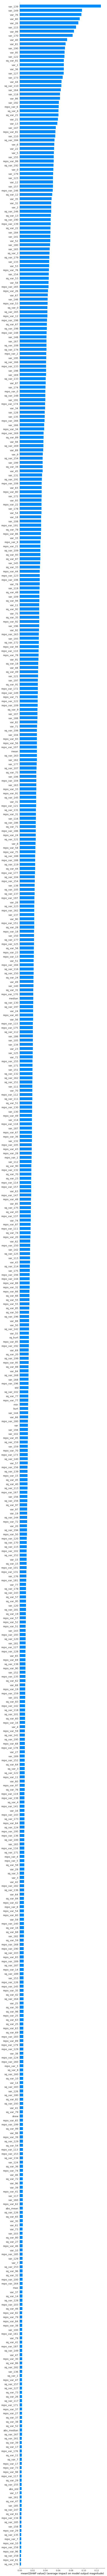

In [25]:
shap.summary_plot(shap_values, X, plot_type="bar",max_display=700)

In [33]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

In [57]:
reduced_features = importance_df[importance_df.shap_importance > 0].column_name
reduced_features = list(reduced_features)
reduced_features[:10], len(reduced_features)

(['var_139',
  'var_149',
  'var_76',
  'var_80',
  'var_26',
  'var_115',
  'var_99',
  'var_170',
  'var_40',
  'var_81'],
 612)

In [58]:
X = X[reduced_features]
X.head()

,var_139,var_149,var_76,var_80,var_26,var_115,var_99,var_170,var_40,var_81,...,var_158,repo_var_29,sq_var_135,repo_var_7,repo_var_10,repo_var_158,repo_var_96,sq_var_158,repo_var_61,sq_var_176
0,15.6599,17.9244,-2.3440,13.6468,-5.1488,1.5093,-3.4132,-4.7645,-5.2387,13.8372,...,17.6054,0.166764,9.825090,0.053687,0.341857,0.056801,0.111555,309.950109,0.201654,102.505500
1,16.1622,-4.4223,3.2709,2.5462,-11.7684,4.1569,0.6939,5.5378,-11.1147,18.1782,...,22.3949,1.824485,80.857862,0.060482,-2.480159,0.044653,0.040343,501.531546,-0.138089,52.348119
2,8.6674,-1.2681,4.5048,7.4729,-7.9940,2.9044,-0.0269,-7.0927,-13.5174,15.7811,...,33.8820,0.162763,137.400595,0.068421,-3.077870,0.029514,0.049012,1147.989924,-0.096400,0.096348
3,8.9821,2.3701,11.6875,0.7839,0.8135,-2.5459,1.9480,-7.1541,-3.8294,10.5404,...,19.9750,0.352026,3.836114,0.067002,0.433633,0.050063,0.088031,399.000625,-0.039965,141.065504
4,13.9547,9.9110,1.0273,2.9598,3.1736,-3.6135,0.6715,1.4493,-5.5963,13.3317,...,27.0846,0.126021,41.899729,0.051944,-0.105867,0.036921,0.067914,733.575557,-0.036044,11.193039


In [59]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
trn_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
model = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.933591	valid_1's auc: 0.894132
[10000]	training's auc: 0.955522	valid_1's auc: 0.896893
[15000]	training's auc: 0.971596	valid_1's auc: 0.896771
Early stopping, best iteration is:
[11527]	training's auc: 0.960965	valid_1's auc: 0.897044
CPU times: user 23min 34s, sys: 8min 2s, total: 31min 36s
Wall time: 4min 1s


In [63]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [64]:
%%time
skf = StratifiedKFold(n_splits=10)
models = []
for train_idx, test_idx in skf.split(X.values, y.values):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_tr, y_tr = augment(X_train.values, y_train.values)
        X_tr = pd.DataFrame(X_tr)
        trn_data = lgb.Dataset(X_tr, label=y_tr)
        test_data = lgb.Dataset(X.values[test_idx], label=y.values[test_idx])
        model_lgb     = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, test_data], verbose_eval=5000, early_stopping_rounds = 4000)
        models.append(model_lgb)
        auc = roc_auc_score(y.values[test_idx], model_lgb.predict(X.values[test_idx]))

Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.95074	valid_1's auc: 0.886372
[10000]	training's auc: 0.960856	valid_1's auc: 0.896297
[15000]	training's auc: 0.966516	valid_1's auc: 0.898778
[20000]	training's auc: 0.971262	valid_1's auc: 0.899436
[25000]	training's auc: 0.975424	valid_1's auc: 0.899636
[30000]	training's auc: 0.979142	valid_1's auc: 0.89962
Early stopping, best iteration is:
[27717]	training's auc: 0.977499	valid_1's auc: 0.899721
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.950623	valid_1's auc: 0.888382
[10000]	training's auc: 0.960884	valid_1's auc: 0.897553
[15000]	training's auc: 0.966571	valid_1's auc: 0.899422
[20000]	training's auc: 0.971274	valid_1's auc: 0.89958
Early stopping, best iteration is:
[19439]	training's auc: 0.970774	valid_1's auc: 0.899705
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.950923	valid_1's auc: 0.882725
[10

In [65]:
with open("models.pickle","wb") as handle:
    pickle.dump(models,handle)